# Part 1: Introduction




For our final project, we sought to better understand the drivers of pricing for various ride-hailing services—namely, Uber and Lyft, in the year 2018 in Boston. Understanding the factors that drive pricing is essential not only for optimizing ride costs but also for informing business strategies and guiding potential regulatory frameworks. To that end, we selected two datasets from Kaggle user Ravimunde compiled here: https://www.kaggle.com/datasets/ravi72munde/uber-lyft-cab-prices/data.

The first dataset contains over 600,000 trips recorded in November 2018, detailing ride distance, ride type (Uber/Lyft), price, product ID, source, and destination. The second dataset includes weather-related data, such as temperature, pressure, humidity, and wind conditions, all recorded in Boston during the same period. By merging these datasets on location data, we were able to investigate how external factors like weather, time of day, and distance, as well as internal factors such as ride type and product offering, influence pricing.

After merging the datasets based on location and time, we conducted exploratory data analysis (EDA) and statistical tests to uncover the relationships between these variables. Using visualizations like scatter plots, box plots, and line-graphs, we assessed how factors like time of day, weather conditions, and distance influence pricing. Notably, we found that vehicle model and distance  are associated with increased ride prices.

These results are detailed below in our notebook, where we carefully explain the motivation behind each analysis, key takeaways, and how our findings improve our understanding of the complex factors driving ride prices. We hope you find these insights useful, and we look forward to addressing any questions or feedback.

# Part 2: Data Loading and Processing




For this step, we sought to import the relevant libraries for all stages of our report (pre-processing, exploratory data analysis, and model selection). These imports primarily span fundamental libraries such as pandas, matplotlib, numpy, and sklearn.

In [ ]:
import os
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
import statsmodels.api as sm
from google.colab import drive
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

## Part 2.1: Data Loading and Processing for Uber/Lyft


For this step, we are connecting to Google Drive to fetch the cab_rides.csv dataset. We decided to use Google Drive since we are familiar with it from class, and it was the best way we could find to share these two large datasets with all team members.

In [ ]:
drive.mount('/content/drive', force_remount=True)
file_path = '/content/drive/MyDrive/cab_rides.csv'
ride_df = pd.read_csv(file_path)

Mounted at /content/drive


In [ ]:
ride_df.head(10)

distance cab_type     time_stamp              destination  \
0      0.44     Lyft  1544952607890            North Station   
1      0.44     Lyft  1543284023677            North Station   
2      0.44     Lyft  1543366822198            North Station   
3      0.44     Lyft  1543553582749            North Station   
4      0.44     Lyft  1543463360223            North Station   
5      0.44     Lyft  1545071112138            North Station   
6      1.08     Lyft  1543208580200  Northeastern University   
7      1.08     Lyft  1543780384677  Northeastern University   
8      1.08     Lyft  1543818482645  Northeastern University   
9      1.08     Lyft  1543315522249  Northeastern University   

             source  price  surge_multiplier  \
0  Haymarket Square    5.0               1.0   
1  Haymarket Square   11.0               1.0   
2  Haymarket Square    7.0               1.0   
3  Haymarket Square   26.0               1.0   
4  Haymarket Square    9.0               1.0   
5  Haymarket Square   16.5               1.0   
6          Back Bay   10.5               1.0   
7          Back Bay   16.5               1.0   
8          Back Bay    3.0               1.0   
9          Back Bay   27.5               1.0   

                                     id    product_id          name  
0  424553bb-7174-41ea-aeb4-fe06d4f4b9d7     lyft_line        Shared  
1  4bd23055-6827-41c6-b23b-3c491f24e74d  lyft_premier           Lux  
2  981a3613-77af-4620-a42a-0c0866077d1e          lyft          Lyft  
3  c2d88af2-d278-4bfd-a8d0-29ca77cc5512   lyft_luxsuv  Lux Black XL  
4  e0126e1f-8ca9-4f2e-82b3-50505a09db9a     lyft_plus       Lyft XL  
5  f6f6d7e4-3e18-4922-a5f5-181cdd3fa6f2      lyft_lux     Lux Black  
6  462816a3-820d-408b-8549-0b39e82f65ac     lyft_plus       Lyft XL  
7  474d6376-bc59-4ec9-bf57-4e6d6faeb165      lyft_lux     Lux Black  
8  4f9fee41-fde3-4767-bbf1-a00e108701fb     lyft_line        Shared  
9  8612d909-98b8-4454-a093-30bd48de0cb3   lyft_luxsuv  Lux Black XL

Analyzing the above table, we notice that the time_stamp variable encoding date/time is in Epoch time, so we will be converting it to date-time. We notice that the date is in milliseconds, as opposed to the standard unit of seconds. We know this since attempting to convert data with seconds give us an invalid time frame. Since we have extracted a more meaningful (for our purposes) unit of time, we decide to drop the old column encoding Epoch time.


In [ ]:
ride_df['time'] = pd.to_datetime(ride_df['time_stamp'], unit='ms').dt.floor('T')
ride_df.drop(columns=['time_stamp'], inplace=True)
ride_df.head()

<ipython-input-4-9c0d4144d21a>:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  ride_df['time'] = pd.to_datetime(ride_df['time_stamp'], unit='ms').dt.floor('T')


distance cab_type    destination            source  price  \
0      0.44     Lyft  North Station  Haymarket Square    5.0   
1      0.44     Lyft  North Station  Haymarket Square   11.0   
2      0.44     Lyft  North Station  Haymarket Square    7.0   
3      0.44     Lyft  North Station  Haymarket Square   26.0   
4      0.44     Lyft  North Station  Haymarket Square    9.0   

   surge_multiplier                                    id    product_id  \
0               1.0  424553bb-7174-41ea-aeb4-fe06d4f4b9d7     lyft_line   
1               1.0  4bd23055-6827-41c6-b23b-3c491f24e74d  lyft_premier   
2               1.0  981a3613-77af-4620-a42a-0c0866077d1e          lyft   
3               1.0  c2d88af2-d278-4bfd-a8d0-29ca77cc5512   lyft_luxsuv   
4               1.0  e0126e1f-8ca9-4f2e-82b3-50505a09db9a     lyft_plus   

           name                time  
0        Shared 2018-12-16 09:30:00  
1           Lux 2018-11-27 02:00:00  
2          Lyft 2018-11-28 01:00:00  
3  Lux Black XL 2018-11-30 04:53:00  
4       Lyft XL 2018-11-29 03:49:00

In [ ]:
unique_count = ride_df['id'].nunique()
print(unique_count)

693071


Furthermore, we see that there are 693k unique ids. Considering this probably corresponds to cabs belonging to specific drivers, we conclude that this should not be a significant predictor for price. We will be dropping it.

In [ ]:
ride_df.drop(columns=['id'], inplace=True)
ride_df.head()

distance cab_type    destination            source  price  \
0      0.44     Lyft  North Station  Haymarket Square    5.0   
1      0.44     Lyft  North Station  Haymarket Square   11.0   
2      0.44     Lyft  North Station  Haymarket Square    7.0   
3      0.44     Lyft  North Station  Haymarket Square   26.0   
4      0.44     Lyft  North Station  Haymarket Square    9.0   

   surge_multiplier    product_id          name                time  
0               1.0     lyft_line        Shared 2018-12-16 09:30:00  
1               1.0  lyft_premier           Lux 2018-11-27 02:00:00  
2               1.0          lyft          Lyft 2018-11-28 01:00:00  
3               1.0   lyft_luxsuv  Lux Black XL 2018-11-30 04:53:00  
4               1.0     lyft_plus       Lyft XL 2018-11-29 03:49:00

In [ ]:
ride_df.dtypes

distance                   float64
cab_type                    object
destination                 object
source                      object
price                      float64
surge_multiplier           float64
product_id                  object
name                        object
time                datetime64[ns]
dtype: object

Realizing we have a few categorical variables, we decide that we want to know every different value that might go into them. We print out the total unique values for each column below:

In [ ]:
unique_cab_type = ride_df['cab_type'].unique()
print(unique_cab_type)

['Lyft' 'Uber']


In [ ]:
unique_location_one = ride_df['destination'].unique()
unique_location_two = ride_df['source'].unique()

unique_location = set(unique_location_one).union(set(unique_location_two))
print(unique_location)

{'Haymarket Square', 'Financial District', 'South Station', 'Beacon Hill', 'Fenway', 'North End', 'North Station', 'Northeastern University', 'Theatre District', 'West End', 'Boston University', 'Back Bay'}


In [ ]:
unique_product_id = ride_df['product_id'].unique()
print(unique_product_id)

['lyft_line' 'lyft_premier' 'lyft' 'lyft_luxsuv' 'lyft_plus' 'lyft_lux'
 '6f72dfc5-27f1-42e8-84db-ccc7a75f6969'
 '6c84fd89-3f11-4782-9b50-97c468b19529'
 '55c66225-fbe7-4fd5-9072-eab1ece5e23e'
 '9a0e7b09-b92b-4c41-9779-2ad22b4d779d'
 '6d318bcc-22a3-4af6-bddd-b409bfce1546'
 '997acbb5-e102-41e1-b155-9df7de0a73f2'
 '8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a']


In [ ]:
unique_name = ride_df['name'].unique()
print(unique_name)

['Shared' 'Lux' 'Lyft' 'Lux Black XL' 'Lyft XL' 'Lux Black' 'UberXL'
 'Black' 'UberX' 'WAV' 'Black SUV' 'UberPool' 'Taxi']


We conclude that we are indeed looking at Uber and Lyft rides. We decide that considering both sources and destinations are locations, we aggragate these districts and present them together. We also see there are a number of set products ids and names, different for Uber and Lyft each.

In [ ]:
ride_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693071 entries, 0 to 693070
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   distance          693071 non-null  float64       
 1   cab_type          693071 non-null  object        
 2   destination       693071 non-null  object        
 3   source            693071 non-null  object        
 4   price             637976 non-null  float64       
 5   surge_multiplier  693071 non-null  float64       
 6   product_id        693071 non-null  object        
 7   name              693071 non-null  object        
 8   time              693071 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), object(5)
memory usage: 47.6+ MB


We want to drop null values. We see that price data is not available for all rows, and since it is price that we want to be able to predict with our model, we decide to drop those values.


In [ ]:
ride_df = ride_df.dropna().reset_index(drop=True)

In [ ]:
ride_df.describe()

distance          price  surge_multiplier  \
count  637976.000000  637976.000000     637976.000000   
mean        2.189261      16.545125          1.015068   
min         0.020000       2.500000          1.000000   
25%         1.270000       9.000000          1.000000   
50%         2.160000      13.500000          1.000000   
75%         2.930000      22.500000          1.000000   
max         7.860000      97.500000          3.000000   
std         1.135413       9.324359          0.095422   

                                time  
count                         637976  
mean   2018-12-05 21:33:49.070748672  
min              2018-11-26 03:40:00  
25%              2018-11-28 22:26:00  
50%              2018-12-02 07:52:00  
75%              2018-12-14 22:45:00  
max              2018-12-18 19:15:00  
std                              NaN

We notice that all distance is relatively small, with only 1.14 standard deviation. This makes sense since our dataset only concerns a handful of locations in Boston. The median price is 13.5 dollars, increasing to as much as 97.5 dollars. This pricing is consistent with past experiences with such services. Looking at the surge multiplyer, we see that there is very little variation (standard deviation is 0.01) in it although the max value is much greater at 3.0. We will investgate this further. Looking at time, we see that the data has been collected over the course of 3 weeks in late November and mid December 2018. We will run an inter-quartile test to identify outliers.

In [ ]:
numerical_cols = ride_df.select_dtypes(include=['number']).columns

Q1 = ride_df[numerical_cols].quantile(0.25)
Q3 = ride_df[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

outliers = (ride_df[numerical_cols] < (Q1 - 1.5 * IQR)) | (ride_df[numerical_cols] > (Q3 + 1.5 * IQR))
print(outliers.sum())

distance             6672
price                5589
surge_multiplier    20975
dtype: int64


Here, notice that distance and price have some number of outliers according to this test. However, because we find the max and min values of both distance and price to be reasonable, we will be keeping these columns. We will, however, look into surge_multiplier further by creating a histogram. Notice that the number of outliers identified for the surge_multiplier is an order of magnitude greater than the other two.

In [ ]:
bins = [0, 1, 2, 3]
ride_df['surge_multiplier_binned'] = pd.cut(ride_df['surge_multiplier'], bins=bins, right=False, labels=["1", "2", "3"])

In [ ]:
bins = [1, 2, 3, 4]
labels = ["1", "2", "3"]

ride_df['surge_multiplier_binned'] = pd.cut(ride_df['surge_multiplier'], bins=bins, right=False, labels=labels)

value_counts = ride_df['surge_multiplier_binned'].value_counts().reset_index()

value_counts.columns = ['Range', 'Count']

fig = px.bar(value_counts,
             x='Range',
             y='Count',
             title='Distribution of Surge Multiplier in Ranges',
             labels={'Range': 'Range', 'Count': 'Count'},
             category_orders={'Range': ['1', '2', '3']}
             )

fig.show()

We see that surge_multiplier is greatly unbalanced. There are 635.571k rows with a surge of 1.0, compared to 2393 in range 2, and just 12 rows with range 3. We decide that there isn't enough variation to make meaningful conclusions on surge_variation. Thus, we will be dropping this column.

In [ ]:
ride_df.drop(columns=['surge_multiplier', 'surge_multiplier_binned'], inplace=True)
ride_df.head()

distance cab_type    destination            source  price    product_id  \
0      0.44     Lyft  North Station  Haymarket Square    5.0     lyft_line   
1      0.44     Lyft  North Station  Haymarket Square   11.0  lyft_premier   
2      0.44     Lyft  North Station  Haymarket Square    7.0          lyft   
3      0.44     Lyft  North Station  Haymarket Square   26.0   lyft_luxsuv   
4      0.44     Lyft  North Station  Haymarket Square    9.0     lyft_plus   

           name                time  
0        Shared 2018-12-16 09:30:00  
1           Lux 2018-11-27 02:00:00  
2          Lyft 2018-11-28 01:00:00  
3  Lux Black XL 2018-11-30 04:53:00  
4       Lyft XL 2018-11-29 03:49:00

## Part 2.2: Data Loading and Processing for Weather


For the same reasons outlined above in 2.1, we will be using Google Drive to access weather.csv

In [ ]:
drive.mount('/content/drive', force_remount=True)
file_path = '/content/drive/MyDrive/weather.csv'
weather_df = pd.read_csv(file_path)

Mounted at /content/drive


In [ ]:
weather_df.head(10)

temp                 location  clouds  pressure    rain  time_stamp  \
0  42.42                 Back Bay     1.0   1012.14  0.1228  1545003901   
1  42.43              Beacon Hill     1.0   1012.15  0.1846  1545003901   
2  42.50        Boston University     1.0   1012.15  0.1089  1545003901   
3  42.11                   Fenway     1.0   1012.13  0.0969  1545003901   
4  43.13       Financial District     1.0   1012.14  0.1786  1545003901   
5  42.34         Haymarket Square     1.0   1012.15  0.2068  1545003901   
6  42.36                North End     1.0   1012.15  0.2088  1545003901   
7  42.21            North Station     1.0   1012.16  0.2069  1545003901   
8  42.07  Northeastern University     1.0   1012.12  0.1020  1545003901   
9  43.05            South Station     1.0   1012.12  0.1547  1545003901   

   humidity   wind  
0      0.77  11.25  
1      0.76  11.32  
2      0.76  11.07  
3      0.77  11.09  
4      0.75  11.49  
5      0.77  11.49  
6      0.77  11.46  
7      0.77  11.37  
8      0.78  11.28  
9      0.75  11.58

We see that, just like in the above section, the time_stamp variable encoding date/time is in Epoch time, so we will be converting it to date-time. This time, we notice that the date is in seconds. Since we have extracted a more meaningful (for our purposes) unit of time, we decide to drop the old column encoding Epoch time.


In [ ]:
weather_df['time'] = pd.to_datetime(weather_df['time_stamp'], unit='s').dt.floor('T')
weather_df.drop(columns=['time_stamp'], inplace=True)
weather_df.head()

<ipython-input-21-623333a65677>:1: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.



temp            location  clouds  pressure    rain  humidity   wind  \
0  42.42            Back Bay     1.0   1012.14  0.1228      0.77  11.25   
1  42.43         Beacon Hill     1.0   1012.15  0.1846      0.76  11.32   
2  42.50   Boston University     1.0   1012.15  0.1089      0.76  11.07   
3  42.11              Fenway     1.0   1012.13  0.0969      0.77  11.09   
4  43.13  Financial District     1.0   1012.14  0.1786      0.75  11.49   

                 time  
0 2018-12-16 23:45:00  
1 2018-12-16 23:45:00  
2 2018-12-16 23:45:00  
3 2018-12-16 23:45:00  
4 2018-12-16 23:45:00

In [ ]:
weather_df.dtypes

temp               float64
location            object
clouds             float64
pressure           float64
rain               float64
humidity           float64
wind               float64
time        datetime64[ns]
dtype: object

In [ ]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6276 entries, 0 to 6275
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   temp      6276 non-null   float64       
 1   location  6276 non-null   object        
 2   clouds    6276 non-null   float64       
 3   pressure  6276 non-null   float64       
 4   rain      894 non-null    float64       
 5   humidity  6276 non-null   float64       
 6   wind      6276 non-null   float64       
 7   time      6276 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 392.4+ KB


Notice the only null values are in the rain column. Assuming rain is null when it is not raining, we will replace null values with 0.0.

In [ ]:
weather_df['rain'] = weather_df['rain'].fillna(0.0)
weather_df.head()

temp            location  clouds  pressure    rain  humidity   wind  \
0  42.42            Back Bay     1.0   1012.14  0.1228      0.77  11.25   
1  42.43         Beacon Hill     1.0   1012.15  0.1846      0.76  11.32   
2  42.50   Boston University     1.0   1012.15  0.1089      0.76  11.07   
3  42.11              Fenway     1.0   1012.13  0.0969      0.77  11.09   
4  43.13  Financial District     1.0   1012.14  0.1786      0.75  11.49   

                 time  
0 2018-12-16 23:45:00  
1 2018-12-16 23:45:00  
2 2018-12-16 23:45:00  
3 2018-12-16 23:45:00  
4 2018-12-16 23:45:00

In [ ]:
weather_df.describe()

temp       clouds     pressure         rain     humidity  \
count  6276.000000  6276.000000  6276.000000  6276.000000  6276.000000   
mean     39.090475     0.677777  1008.445209     0.008212     0.763985   
min      19.620000     0.000000   988.250000     0.000000     0.450000   
25%      36.077500     0.440000   997.747500     0.000000     0.670000   
50%      40.130000     0.780000  1007.660000     0.000000     0.760000   
75%      42.832500     0.970000  1018.480000     0.000000     0.890000   
max      55.410000     1.000000  1035.120000     0.780700     0.990000   
std       6.022055     0.314284    12.870775     0.043021     0.127340   

              wind                           time  
count  6276.000000                           6276  
mean      6.802812  2018-12-03 17:15:53.116634880  
min       0.290000            2018-11-26 03:40:00  
25%       3.517500            2018-11-28 06:34:00  
50%       6.570000            2018-11-29 17:52:00  
75%       9.920000            2018-12-13 08:45:00  
max      18.180000            2018-12-18 18:45:00  
std       3.633466                            NaN

We see that the change in temperature (Fahrenheit) over time is not very dramatic, which makes sense considering the data was collected over the course of 3 weeks. We see then that the date/time of the dataset for weather roughly matches that of the ridesharing dataset. Other values also seem reasonable, tracking atmospheric pressure (mb) force of wind (mph), rain (inches for the last hr), humidity (in %), and cloudiness (from 0 to 1). We conclude that none of the maximum or minimum values strike us as outliers, and we will be keeping all the data.

## Part 2.3: Joining Dataframes

Finally, we will be joining these two dataframes. In order to better understand the relationship between them, we will be providing an ER diagram.

Analyzing the ER diagram, we notice that the relational schema. We have two entities, ride and weather. Ride has the attributes distance, id, product id, source, destination, surge multiplier, name, price, epoch time, and car type. It is also possible to calculate the date (in non-epoch format) as a computed attribute, which is also a compound attribute that in itself holds year, month, day, hour, minute, and second. Weather has the attributes humidity, wind, clouds, epoch time, temperature, rain, location and pressure. It is also possible to calculate the date (in non-epoch format) as a computed attribute, which is also a compound attribute that in itself holds year, month, day, hour, minute, and second. The relationships between the two entities is represented by 'called', as it is possible to call a ride in a given weather. Each ride must be called under 1 unique weather condition, whereas multiple rides can be called under the same weather condition.

We want to figure out a way to join these two datasets. Notice that these two entities have two attributes in common, location vs. source/destination and epoch time (then, consequently date). Thus, it makes sense to join these two datasets on these attributes. We conclude that it makes sense to only join location on source, as there is very little difference in weather measurements taken at the same time in what we have seen to be very proximate locations. We conclude that an inner-join is appropiate for our purposes as we only want to keep rows that have matching values in both tables. This is so we do not keep data we are unable to match, since it would not aid in our investigation into factors that go into ride prices, including the weather.

In [ ]:
weather_df = weather_df.rename(columns={'location': 'source'})

df = pd.merge(ride_df, weather_df, on=['time', 'source'], how='inner')
df.head()

distance cab_type              destination         source  price  \
0      1.08     Lyft  Northeastern University       Back Bay   16.5   
1      1.08     Lyft  Northeastern University       Back Bay   27.5   
2      0.72     Lyft         Haymarket Square  North Station   13.5   
3      3.24     Lyft  Northeastern University  North Station   19.5   
4      2.94     Uber                   Fenway  North Station    9.0   

                             product_id          name                time  \
0                              lyft_lux     Lux Black 2018-12-02 19:53:00   
1                           lyft_luxsuv  Lux Black XL 2018-11-27 10:45:00   
2                          lyft_premier           Lux 2018-11-26 07:46:00   
3                          lyft_premier           Lux 2018-12-14 19:45:00   
4  997acbb5-e102-41e1-b155-9df7de0a73f2      UberPool 2018-12-15 06:45:00   

    temp  clouds  pressure    rain  humidity  wind  
0  50.49    1.00   1004.05  0.0000      0.92  2.46  
1  44.95    0.99    990.87  0.0087      0.97  6.14  
2  41.20    0.94   1014.19  0.0000      0.93  1.95  
3  42.70    0.34   1029.36  0.0000      0.65  4.18  
4  45.14    1.00   1022.35  0.0000      0.91  6.26

Furthermore, we decide that since the data is taken over the course of less than a month, it follows that we do not expect a change in prices over time as any reasonable observation. Then, we extract only the time (and discard date).

In [ ]:
df['time'] = df['time'].dt.strftime('%H:%M:%S')
df.head()

distance cab_type              destination         source  price  \
0      1.08     Lyft  Northeastern University       Back Bay   16.5   
1      1.08     Lyft  Northeastern University       Back Bay   27.5   
2      0.72     Lyft         Haymarket Square  North Station   13.5   
3      3.24     Lyft  Northeastern University  North Station   19.5   
4      2.94     Uber                   Fenway  North Station    9.0   

                             product_id          name      time   temp  \
0                              lyft_lux     Lux Black  19:53:00  50.49   
1                           lyft_luxsuv  Lux Black XL  10:45:00  44.95   
2                          lyft_premier           Lux  07:46:00  41.20   
3                          lyft_premier           Lux  19:45:00  42.70   
4  997acbb5-e102-41e1-b155-9df7de0a73f2      UberPool  06:45:00  45.14   

   clouds  pressure    rain  humidity  wind  
0    1.00   1004.05  0.0000      0.92  2.46  
1    0.99    990.87  0.0087      0.97  6.14  
2    0.94   1014.19  0.0000      0.93  1.95  
3    0.34   1029.36  0.0000      0.65  4.18  
4    1.00   1022.35  0.0000      0.91  6.26

We will now be using regex to match on the first two digits of the time. This will turn time from an object to integer, which will be helpful for further analysis.

In [ ]:
df['hour'] = df['time'].str.extract(r'(\d{2}):', expand=False).astype(int)
df.drop(columns=['time'], inplace=True)
df.head()

distance cab_type              destination         source  price  \
0      1.08     Lyft  Northeastern University       Back Bay   16.5   
1      1.08     Lyft  Northeastern University       Back Bay   27.5   
2      0.72     Lyft         Haymarket Square  North Station   13.5   
3      3.24     Lyft  Northeastern University  North Station   19.5   
4      2.94     Uber                   Fenway  North Station    9.0   

                             product_id          name   temp  clouds  \
0                              lyft_lux     Lux Black  50.49    1.00   
1                           lyft_luxsuv  Lux Black XL  44.95    0.99   
2                          lyft_premier           Lux  41.20    0.94   
3                          lyft_premier           Lux  42.70    0.34   
4  997acbb5-e102-41e1-b155-9df7de0a73f2      UberPool  45.14    1.00   

   pressure    rain  humidity  wind  hour  
0   1004.05  0.0000      0.92  2.46    19  
1    990.87  0.0087      0.97  6.14    10  
2   1014.19  0.0000      0.93  1.95     7  
3   1029.36  0.0000      0.65  4.18    19  
4   1022.35  0.0000      0.91  6.26     6

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58796 entries, 0 to 58795
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   distance     58796 non-null  float64
 1   cab_type     58796 non-null  object 
 2   destination  58796 non-null  object 
 3   source       58796 non-null  object 
 4   price        58796 non-null  float64
 5   product_id   58796 non-null  object 
 6   name         58796 non-null  object 
 7   temp         58796 non-null  float64
 8   clouds       58796 non-null  float64
 9   pressure     58796 non-null  float64
 10  rain         58796 non-null  float64
 11  humidity     58796 non-null  float64
 12  wind         58796 non-null  float64
 13  hour         58796 non-null  int64  
dtypes: float64(8), int64(1), object(5)
memory usage: 6.3+ MB


# Part 3: Exploratory Data Analysis

After processing the data and making basic changes, we sought to deepen our understanding by exploring the relationships between key feature combinations. The selection of these combinations was guided by both statistical relevance and their intuitive importance in shaping the development of our model.

## Part 3.1: Percentage of Lyft and Uber Rides

In [ ]:
total_rides = df.shape[0]

uber_rides = df[df['cab_type'] == 'Uber'].shape[0]
lyft_rides = df[df['cab_type'] == 'Lyft'].shape[0]

uber_percentage = (uber_rides / total_rides) * 100
lyft_percentage = (lyft_rides / total_rides) * 100

print(f"Percentage of Uber rides: {uber_percentage:.2f}%")
print(f"Percentage of Lyft rides: {lyft_percentage:.2f}%")

Percentage of Uber rides: 51.86%
Percentage of Lyft rides: 48.14%


The percentage of Uber vs. Lyft rides are very similar, and thus it is possible to conclude that we have enough and balanced data on both companies to analyze going further.

## Part 3.2: Prices over Time

To begin, we chose to visualize the average prices of rides over time. We will be tracking Uber and Lyft differently as we are interested in the potential price differencies between these two companies. We decided to use a line graph to track the differences in average prices over a short amount of time. Through this analysis, we'd get a sense of whether price fluctuates over time, and whether time might be a factor influencing price.

In [ ]:
df_grouped = df.groupby(['hour', 'cab_type']).agg({
    'price': 'mean'
}).reset_index()

In [ ]:
fig = px.line(df_grouped,
              x='hour',
              y='price',
              color='cab_type',
              title='Average Ride Price for Uber and Lyft Over Time',
              labels={'hour': 'Hour of Day', 'price': 'Average Ride Price'},
              markers=True)

fig.show()

We have the following take-aways:


*   On average, Lyft prices are higher than Uber prices all hours of the day. This might support the conclusion that Lyft and Uber price their services differently. It is also possible to see that the companies exhibit different trends. For example, as Uber prices drop during the evening, Lyft prices increase.
*   It is possible to identify general trends and behaviors. It might seem like 5 PM - 8 PM might be some sort of a rush hour, the pricing oof both services increase on average during this time.

Both of these take-aways suggest that the time of day might influence the pricing of both companies differently.

## Part 3.3: Locations of Rides

We also decided to examine rides by location to gain a better understanding of whether there was geographical concentration of ride locations in Boston. If there was, then that suggests the external validity of our model beyond this subset of locations is likely to be low, as we will primarily be working with data that is concentrated over a small area and thus reflective mostly of that partiular concentration. It also provides a more intuitave way to understand distances as recorded by the dataset. After fethcing the general coordinates of every unique location mentioned in the combined dataset, we decided to use Folium to visualize the ride locations in Boston.


In [ ]:
locations = {
    'Financial District': (42.3573, -71.0598),
    'Northeastern University': (42.3370, -71.0892),
    'North Station': (42.3656, -71.0620),
    'Boston University': (42.3505, -71.1054),
    'Back Bay': (42.3601, -71.0657),
    'North End': (42.3646, -71.0542),
    'Haymarket Square': (42.3635, -71.0603),
    'Fenway': (42.3419, -71.0951),
    'West End': (42.3641, -71.0694),
    'South Station': (42.3525, -71.0552),
    'Beacon Hill': (42.3600, -71.0700),
    'Theatre District': (42.3523, -71.0620)
}

location_df = pd.DataFrame(locations.items(), columns=['location', 'coords'])
location_df[['latitude', 'longitude']] = pd.DataFrame(location_df['coords'].to_list(), index=location_df.index)

f = folium.Figure(width=1000, height=1000)

m = folium.Map(width=1000, height=1000, location=[42.3601, -71.0589], zoom_start=13, min_zoom=10, max_zoom=16)

location_df.apply(lambda row: folium.Marker(
    location=[row["latitude"], row["longitude"]],
    popup=folium.Popup(row["location"], max_width=200),
    icon=folium.Icon(color='blue', icon='info-sign')
).add_to(m), axis=1)

m




*   Most locations are in the center of Boston, and thus very close to each other. Thus, we can ruminate that in addition to being localized to Boston, our model would probably be better tuned in making short distance predictions as this seems to be the crux of our data.
*   There are three locations that are farther from others in the graph, but they all lie in the general direction of Southwest Boston. Thus, the data most likely contains cabs that operate in the same radius.





## Part 3.4: Price Distributions of Rides

Beyond developing an initial understanding of the dataset, we also sought to better understand how ride price was distributed. Even though this is the variable that we intend to predict (our dependent variable), it's important to understand, generally, the distributions that our predictions may follow. Furthermore, due to underlying heterogeneity within our data, it's also important to understand how listing price may vary with various factors such as the type of vehicle, distance, weather, location and more. Thus, our production of a histogram, box and whisker plots, and other analysis helps us better understand how we'd expect our dependent variable to be distributed within our model outputs.

### Part 3.4.1: Price Distribution Histogram

---



We decided to use a histogram to visualize the underlying distributions of prices, including the mode and the extremeties of our data.

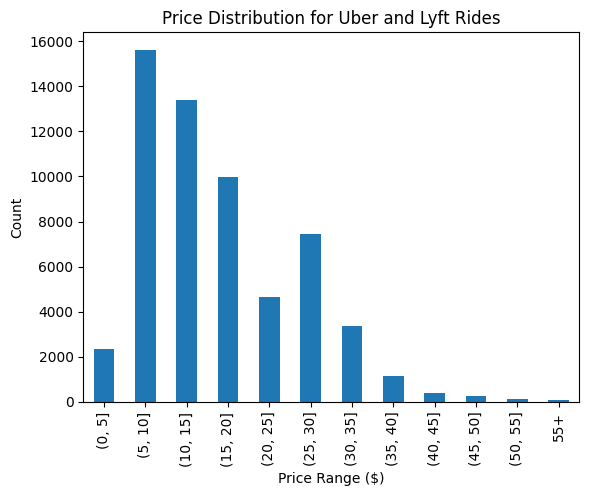

In [ ]:
bins = pd.IntervalIndex.from_tuples([(0, 5), (5, 10), (10, 15), (15, 20), (20, 25),
                                     (25, 30), (30, 35), (35, 40), (40, 45), (45, 50),
                                     (50, 55), (55, 200)])

price_counts = pd.cut(df['price'], bins)

price_counts = price_counts.astype(str).replace(r'\(55, 200\]', '55+', regex=True)

price_counts = price_counts.value_counts(sort=False)

ordered_bins = ['(0, 5]', '(5, 10]', '(10, 15]', '(15, 20]', '(20, 25]',
                '(25, 30]', '(30, 35]', '(35, 40]', '(40, 45]', '(45, 50]',
                '(50, 55]', '55+']

price_counts = price_counts.reindex(ordered_bins, fill_value=0)

price_counts.plot(kind='bar')

plt.title('Price Distribution for Uber and Lyft Rides')
plt.xlabel('Price Range ($)')
plt.ylabel('Count')

plt.show()

The histogram graph shows that the vast majority of rides lie in the 5 dollars to 20 dollars range, and the graph has a skew to the right. This makes sense, as rides that cost less than 5 dollars are rare, since they are not as profitable. Rides that cost more than 40 dollars are extremely rare, this might reflect the general pricing window for ridesharing but is also most likely affected by the fact that the locations represented are very compact and close-by, and thus very little long distance rides are recorded in the dataset.

### Part 3.4.2: Price Distribution by Vehicle Type

Furthermore, we decide to use a box & whisker plot to visualize the price distributions of each type of vehicle. Notice there are 12 vehicle types in total, 6 belonging to Lyft and 7 belonging to Uber.

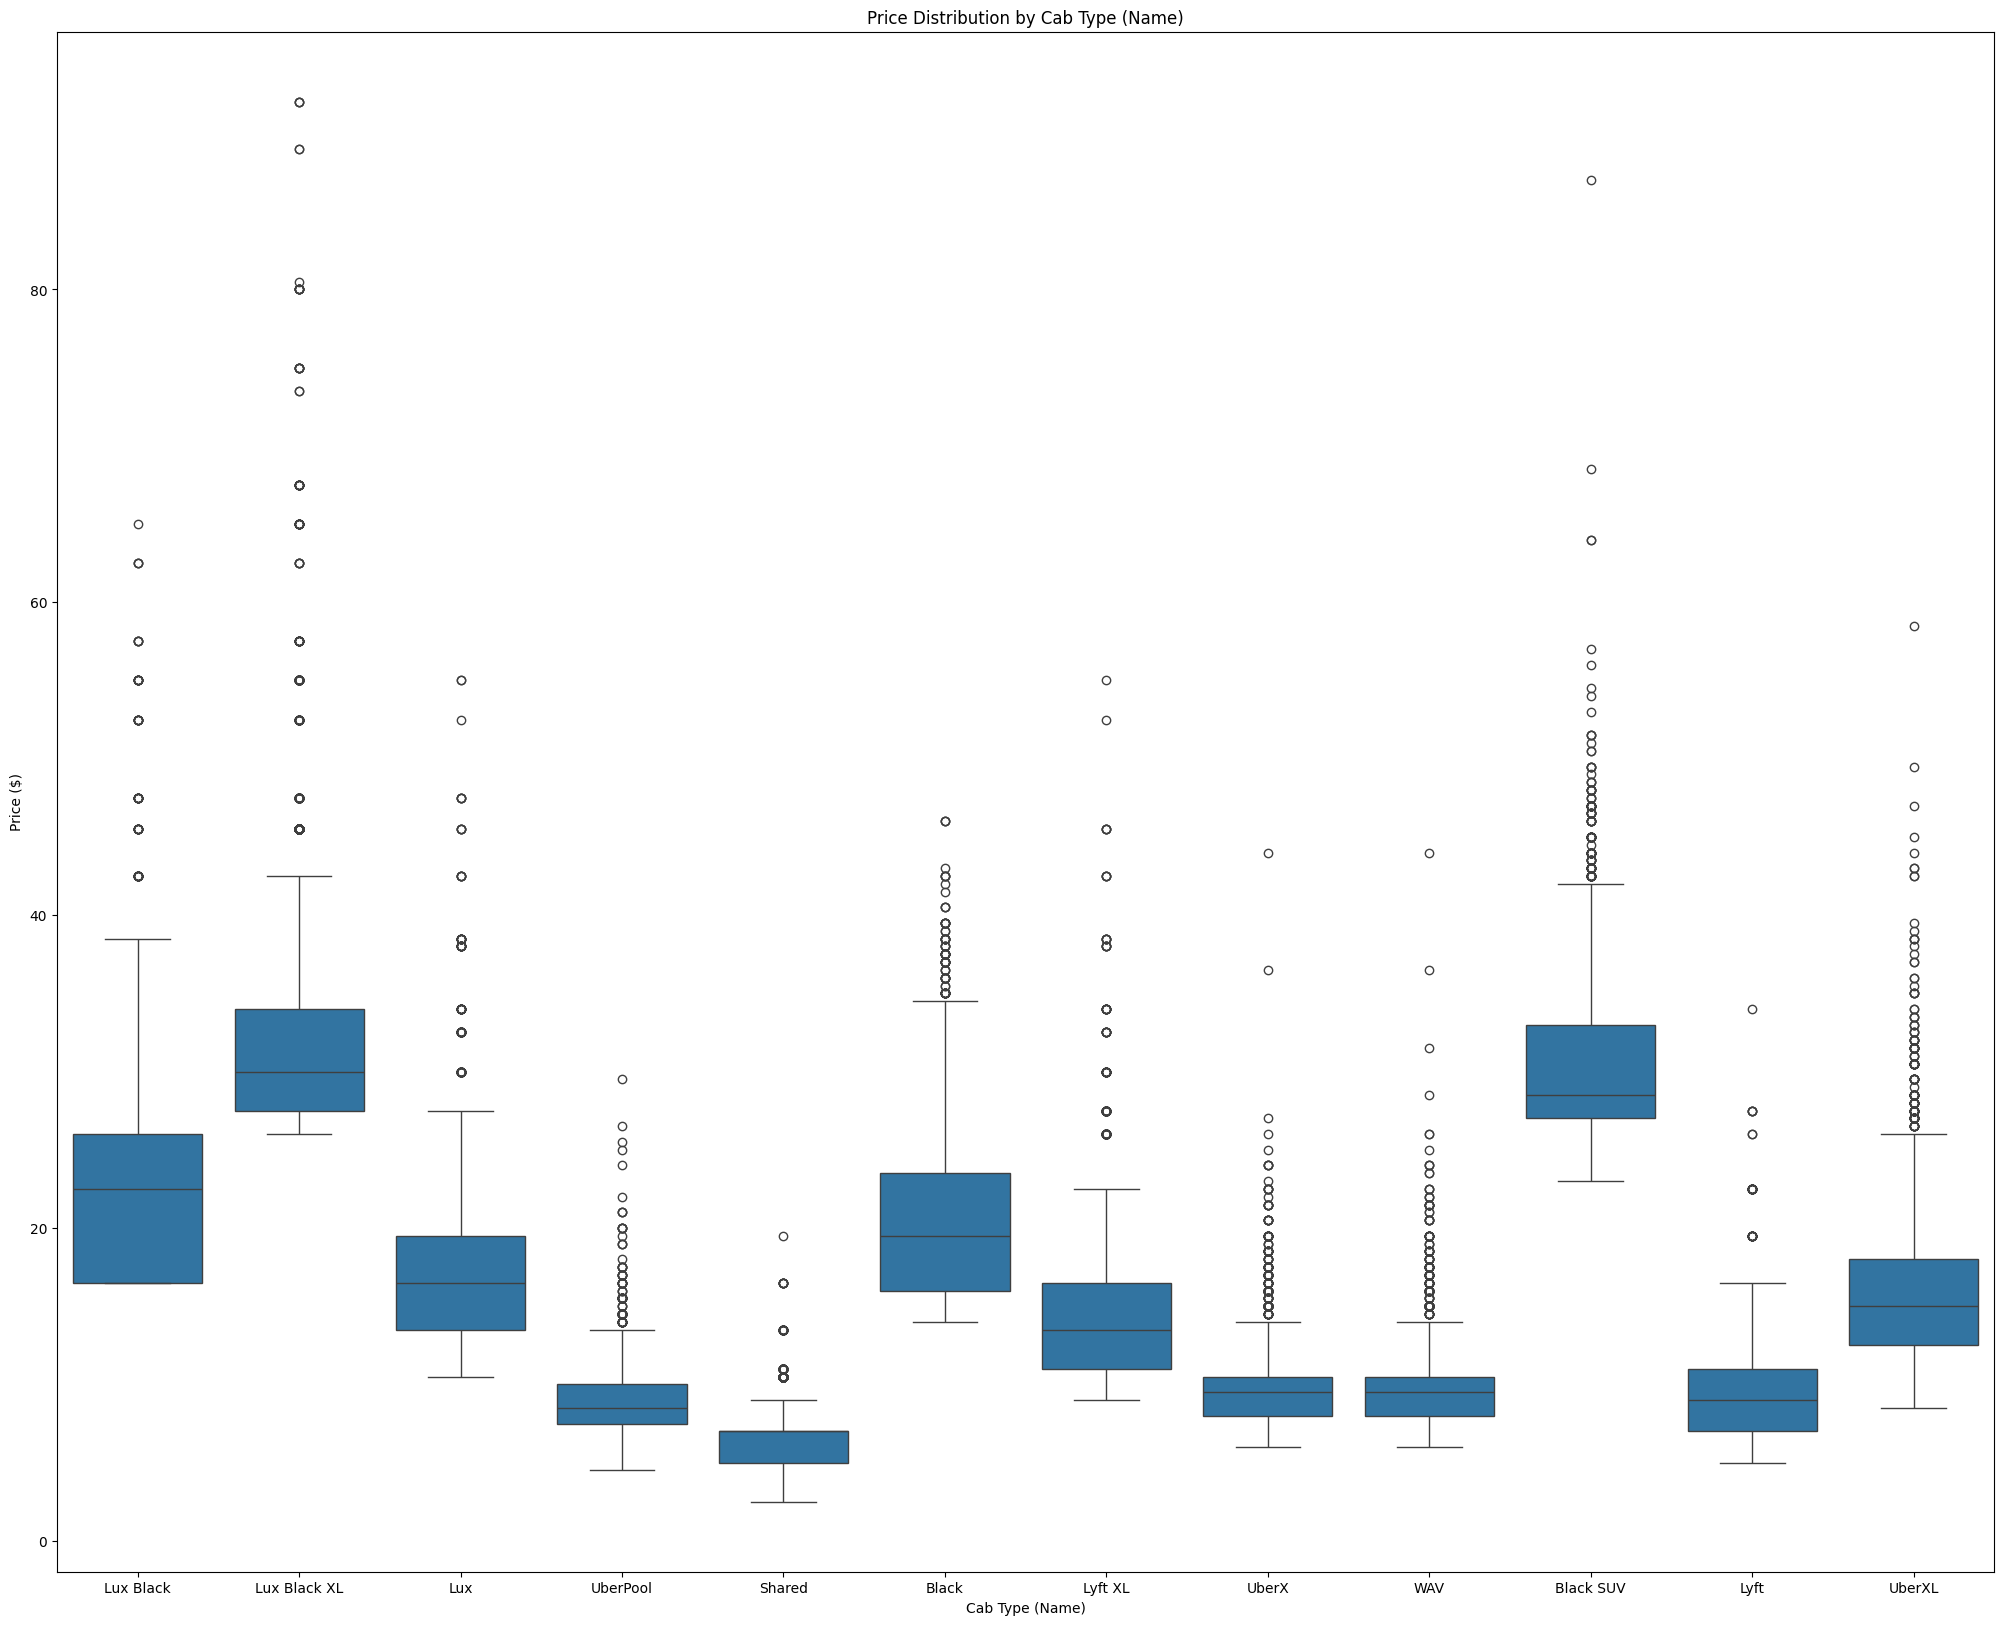

In [ ]:
plt.figure(figsize=(25, 20))
sns.boxplot(x='name', y='price', data=df)

plt.title('Price Distribution by Cab Type (Name)')
plt.xlabel('Cab Type (Name)')
plt.ylabel('Price ($)')

plt.show()

We make the following observations:

*   The price distribution changes significantly based on vehicle type, signalling that the type of vehicle might be an important predictor in ride pricing.
*   All outliers are distributed in higher prices, showing that rides might cost significantly more based on other factors, but they tend to not cost signifiantly less.
*   The greatest median price belongs to the Lux Black SUV, followed by the Black SUV. This makes sense as they're labeling indiciates they're luxury services, and thus one would expect them to cost more.
*   The least median price belonga to the Shared and then UberPool services. Considering these are low budget options intended for travelers who want to ride-share, this result makes sense.
* Cheaper services on average have the least amount of varience in their pricing, whereas more expensive services experience great varience. This might be explained by other factors contributing to the pricing of rides differently based on vehicle type.  





### Part: 3.4.3: Selected Price Distributions over Source/Destination

Here, we initially wanted to analyze the price distributions of every source/destination pair in the dataset using box & whiskers. However, this took too much computation power and resulted in crashes. Forced to downscale, here, we are analyzing four sample source/destination pairs (Beacon Hill to Haymarket Square, Beacon Hill to Fenway, Fenway to Beacon Hill, and Haymarket Square to Beacon Hill) to see if this microcosm will provide any useful insights towards the overall picture. We picked Beacon Hill and Haymarket Square as they are central districts in Boston very closely located to each other. Furthermore, we picked Fenway because it is far away from both Beacon Hill and Haymarket Square.

In [ ]:
selected_routes = [
    ('Beacon Hill', 'Haymarket Square'),
    ('Beacon Hill', 'Fenway')
]

df_filtered = df[df[['source', 'destination']].apply(tuple, axis=1).isin(selected_routes)]

fig = px.box(df_filtered,
             x='destination',
             y='price',
             color='cab_type',
             facet_col='source',
             category_orders={"destination": ["Haymarket Square", "Fenway"]},
             title="Price Distribution for Uber and Lyft (Beacon Hill to Selected Destinations)",
             labels={"price": "Price ($)", "destination": "Destination", "cab_type": "Cab Type"}
            )

fig.show()

selected_routes_from = [
    ('Haymarket Square', 'Beacon Hill'),
    ('Fenway', 'Beacon Hill')
]

df_filtered_from = df[df[['source', 'destination']].apply(tuple, axis=1).isin(selected_routes_from)]

fig2 = px.box(df_filtered_from,
              x='source',
              y='price',
              color='cab_type',
              facet_col='destination',
              category_orders={"source": ["Haymarket Square", "Fenway"]},
              title="Price Distribution for Uber and Lyft (Selected Destinations to Beacon Hill)",
              labels={"price": "Price ($)", "source": "Source", "cab_type": "Cab Type"}
             )

fig2.show()


We have the following take-aways:

*   It is clear that for both graphs, the trip consisting of locations Fenway and Beacon Hill is cheaper. This makes sense, as this is the one with the shorter distance. Furthermore, this observation holds accross both Uber and Lyft.

*  Although similar, we notice that the distribution of trips from Beacon Hill to a location vs. location to Beacon Hill is slightly different. We observe different variations and different outliers. This might suggest that the distance between these places are not the only consideration, and other factors might be affecting the differences between trips.



### Part 3.4.4: Price Distribution over Distances

We decide to explore this difference in price between the same distances further. We will create a line graph with Plotly to analyze the change in price as distance changes, for both Uber and Lyft to see if there are any differences in these two companies. This will help us better understand how distances affect pricing for each company.

In [ ]:
uber_data = df[df['cab_type'] == 'Uber']
lyft_data = df[df['cab_type'] == 'Lyft']

fig_uber = px.scatter(
    uber_data,
    x='distance',
    y='price',
    title="Price vs Distance for Uber",
    labels={'distance': 'Distance (miles)', 'price': 'Price ($)', 'cab_type': 'Cab Type'},
    color_discrete_sequence=["blue"],
)


fig_uber.show()

fig_lyft = px.scatter(
    lyft_data,
    x='distance',
    y='price',
    title="Price vs Distance for Lyft",
    labels={'distance': 'Distance (miles)', 'price': 'Price ($)', 'cab_type': 'Cab Type'},
    color_discrete_sequence=["red"],
)

fig_lyft.show()

Takeaways:

*   There tends to be an increase of prices as distance increases.
*    This observation is more clear with Uber, where it is possible to see how a best fit line would be able to be fitted on the data.
*   Lyft, on the other hand, has a less linear distribution. It seems like Lyft prices demonstrate some stratification, where it is possible to draw horizontal lines of pricing accross distances. These tiers might be connected to different vehicles supplied by Lyft.
*   In conclusion, although distance is an important metric for both companies, it seems that it is more predictive of Uber pricing.





### Part 3.4.5: Price Distribution over Weather

Finally, we decided to look at how weather affects pricing. We will be analyzing the effects of every attribute in the weather dataset to see if any patterns can be identified to inform our analysis moving forward.

In [ ]:
weather_features = ['clouds', 'pressure', 'rain', 'humidity', 'wind']

for feature in weather_features:
    fig = px.scatter(df,
                     x=feature,
                     y='price',
                     color='cab_type',
                     title=f"Price vs {feature.capitalize()} for Uber and Lyft",
                     labels={feature: feature.capitalize(), 'price': 'Price ($)', 'cab_type': 'Cab Type'},
                     opacity=0.7)

    fig.update_traces(marker=dict(size=10))

    fig.show()

Overall, it seems that there isn't a very noticable relationship between weather trends and pricing. For every graph, the distribution over weather trends is largely horizontal, and does not show a noticable trend. In the rain graph, it can be seen that we have a lot of data point on no rain and little rain, but do not have many for heavy rain. This is a potental limitation of the data, and we would have ideally liked a more homogenous distribution of rain. The graphs do largely show, however, that most Lyft and Uber rides have similar pricing, but Lyft seems to have greater outliers. We thought this take-away was worth keeping these graphs for, especially considering weather is a significant part of our analysis.



## Part 3.5: Feature Correlation HeatMap

We will first be performing a One-Hot Encoding for categorical variables. We will need them to be numerical values in the regression, and we are doing this step before the heatmap to also check the correlation of our categorical variables.


In [ ]:
df = pd.get_dummies(df, columns=['cab_type', 'destination', 'source', 'product_id', 'name'], drop_first=True)

print("\nColumns after One-Hot Encoding (subset):")
print(df.columns[:10])


Columns after One-Hot Encoding (subset):
Index(['distance', 'price', 'temp', 'clouds', 'pressure', 'rain', 'humidity',
       'wind', 'hour', 'cab_type_Uber'],
      dtype='object')


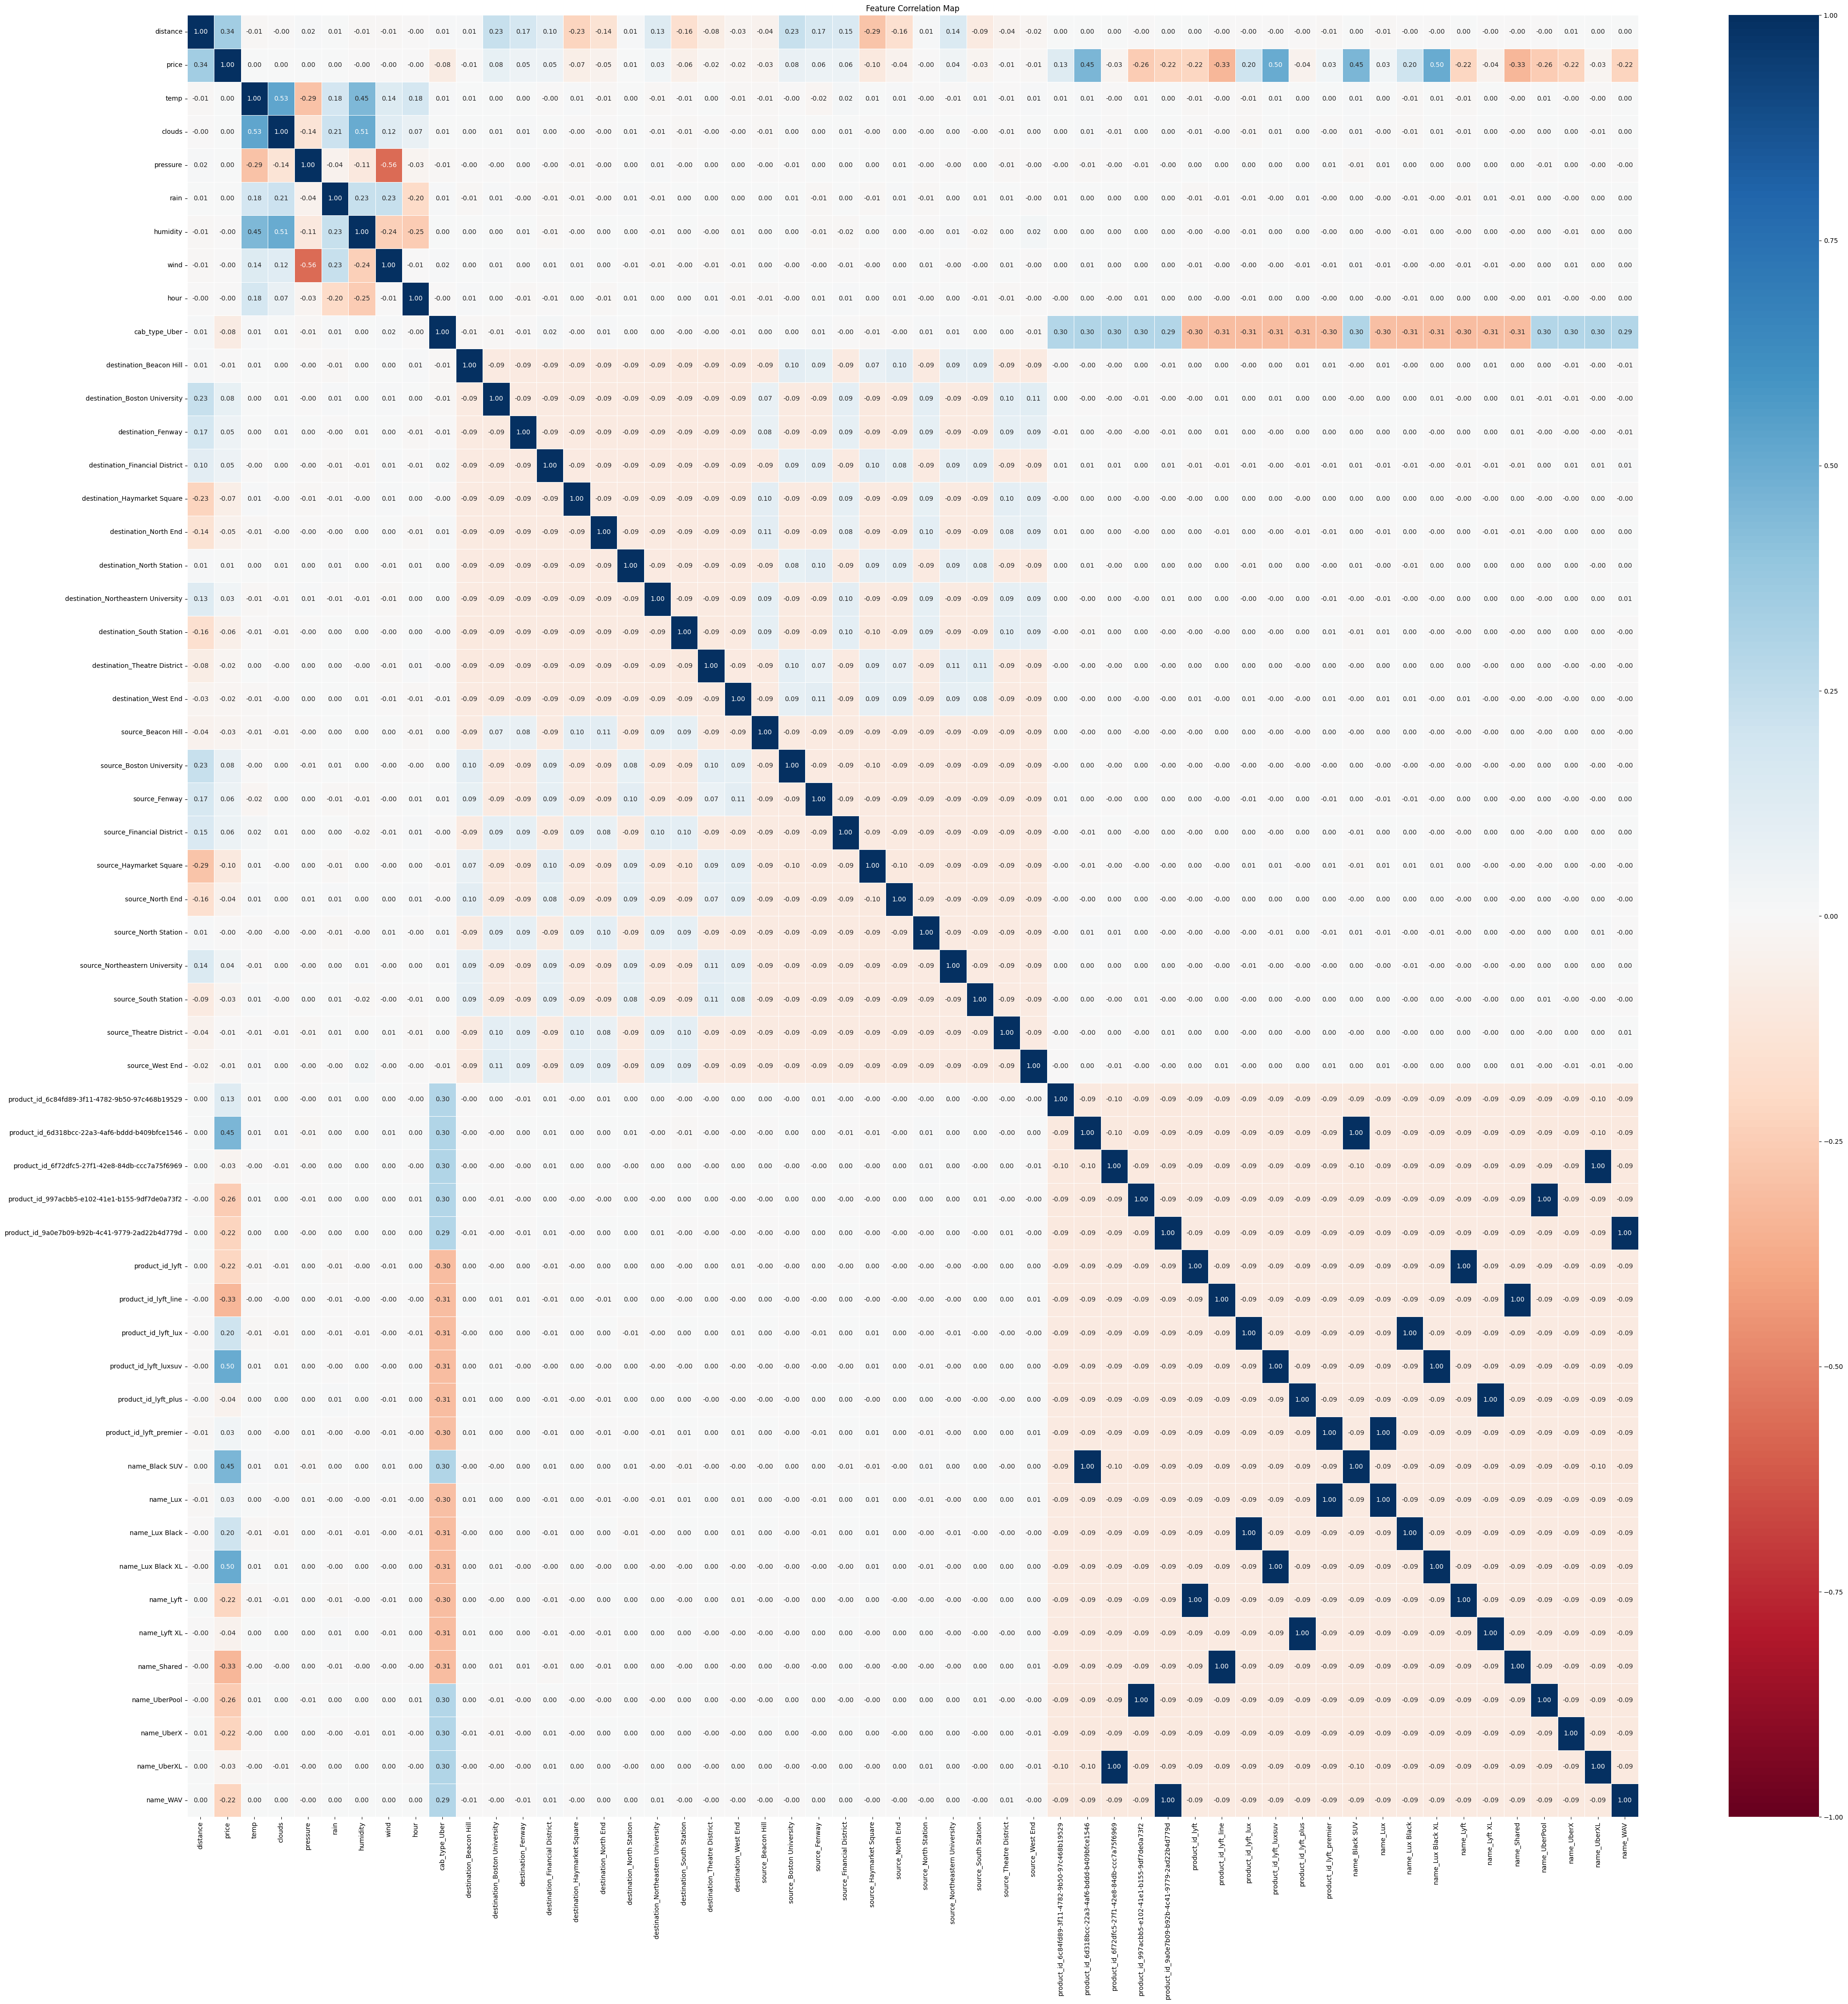

In [ ]:
corr_matrix = df.corr()

plt.figure(figsize=(50, 50))
sns.heatmap(corr_matrix, cmap='RdBu', vmin=-1, vmax=1, annot=True, fmt=".2f", center=0, linewidths=0.5)

plt.title('Feature Correlation Map')

plt.show()

We notice that there is a positive correlation of 1 between product id to name. We notice that there is a 1 to 1 mapping between every product id to a corresponding name. We will thus delete all occurances of product_id, so that we are removing these variables that hold the same values. We conclude that the name is what is presented to the user, and the company indexes these names using their product id.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58796 entries, 0 to 58795
Data columns (total 54 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   distance                                         58796 non-null  float64
 1   price                                            58796 non-null  float64
 2   temp                                             58796 non-null  float64
 3   clouds                                           58796 non-null  float64
 4   pressure                                         58796 non-null  float64
 5   rain                                             58796 non-null  float64
 6   humidity                                         58796 non-null  float64
 7   wind                                             58796 non-null  float64
 8   hour                                             58796 non-null  int64  
 9   cab_type_Uber               

Notice complete correlation between name and product_id. I will delete product_id.

In [ ]:
df.drop(columns=['product_id_lyft_premier', 'product_id_lyft_plus', 'product_id_lyft_luxsuv', 'product_id_lyft_lux', 'product_id_lyft_line',
                 'product_id_lyft', 'product_id_9a0e7b09-b92b-4c41-9779-2ad22b4d779d', 'product_id_997acbb5-e102-41e1-b155-9df7de0a73f2',
                 'product_id_6f72dfc5-27f1-42e8-84db-ccc7a75f6969', 'product_id_6d318bcc-22a3-4af6-bddd-b409bfce1546',
                 'product_id_6c84fd89-3f11-4782-9b50-97c468b19529'], inplace=True)

We also know that since names for Uber and Lyft are unique, we don't need to encode whether the cab type is Uber or Lyft. Thus, we will be removing this redundant column.

In [ ]:
df.drop(columns=['cab_type_Uber'], inplace=True)

 # Part 4: Data Preprocessing and Feature Engineering

## Part 4.1: Splitting the Data into Training and Test Sets

The categorical data was already transfromed into numerical data when we performe One Hot Encoding earlier. As such, the next step to prepare the data for modeling is to split it into training and testing. We chose an 80/20 split. This ensures that the models are trained on a large enough sample while retaining unseen data for evaluation. The target variable is the price of the ride, while all other columns serve as features. random_state is 42, as it is the "default" random seed.

In [ ]:
from sklearn.model_selection import train_test_split
# Define the features (X) and target variable (y)
X = df.drop(['price'], axis=1)
y = df['price']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nTraining and Test Data Shapes:")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")


Training and Test Data Shapes:
X_train: (47036, 41), X_test: (11760, 41)
y_train: (47036,), y_test: (11760,)


##Part 4.2: Feature Scaling

Before applying models that rely on distance or gradient-based methods (the ones we are using are Linear Regression and the NN), we scaled the features using StandardScaler. This transforms the data to have a mean of 0 and std of 1. Random Forest is scale-invariant, and therefore we will also be keeping the original unscaled data to use for that model.

In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler
scaler = StandardScaler()

# Scale the training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nScaled Training and Test Data:")
print("First 5 rows of Scaled Training Data:\n", X_train_scaled[:5])


Scaled Training and Test Data:
First 5 rows of Scaled Training Data:
 [[-0.58000805  0.41438939  1.058204   -1.10640958 -0.21395666 -0.95043007
   0.47259994  1.30680079 -0.30198662  3.34070196 -0.3002228  -0.30395232
  -0.29633468 -0.29501677 -0.30001236 -0.29900087 -0.30876836 -0.30889225
  -0.30240556 -0.29624977 -0.30536909 -0.29849426 -0.29862097 -0.31353591
  -0.30436947 -0.30114756 -0.3013155  -0.29599496 -0.30076948 -0.30361833
  -0.30864442 -0.29232602 -0.29929612  3.38963777 -0.29228318 -0.2955274
  -0.29612238 -0.30777599 -0.30752758 -0.31017066 -0.30416094]
 [ 0.59003513  0.35623598  0.21920499  1.53351783 -0.21395666 -0.21794683
  -0.83304585  1.4457723   3.31140502 -0.29933829 -0.3002228  -0.30395232
  -0.29633468 -0.29501677 -0.30001236 -0.29900087 -0.30876836 -0.30889225
  -0.30240556 -0.29624977 -0.30536909 -0.29849426 -0.29862097  3.18942731
  -0.30436947 -0.30114756 -0.3013155  -0.29599496 -0.30076948 -0.30361833
  -0.30864442 -0.29232602 -0.29929612 -0.29501677 -0.

##Part 4.3: Principle Component Analysis
To address multicollinearity and reduce the dimensionality of the dataset, we applied PCA, choosing to retain 95% of the variance (which we believe to be good enough a balance between dimensionality reduction and model accuracy)

In [ ]:
from sklearn.decomposition import PCA
import numpy as np
# Initialize PCA
pca = PCA(n_components=0.95)  # Retain 95% variance

# Fit PCA on training data and transform both train and test sets
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Print PCA results
print(f"Number of Principal Components Retained: {pca.n_components_}")
print(f"Explained Variance Ratios (First 5): {pca.explained_variance_ratio_[:5]}")
print(f"Cumulative Explained Variance (First 5): {np.cumsum(pca.explained_variance_ratio_)[:5]}")

Number of Principal Components Retained: 33
Explained Variance Ratios (First 5): [0.05471231 0.050942   0.04210632 0.03802027 0.03060499]
Cumulative Explained Variance (First 5): [0.05471231 0.10565431 0.14776063 0.18578091 0.21638589]


###Visualizing Explained Variance

This is to show how much of the total variance is captured by each principal component while perfoming PCA, which will help us determine how many principle components should be retained to capture a signitificant portion of the variability

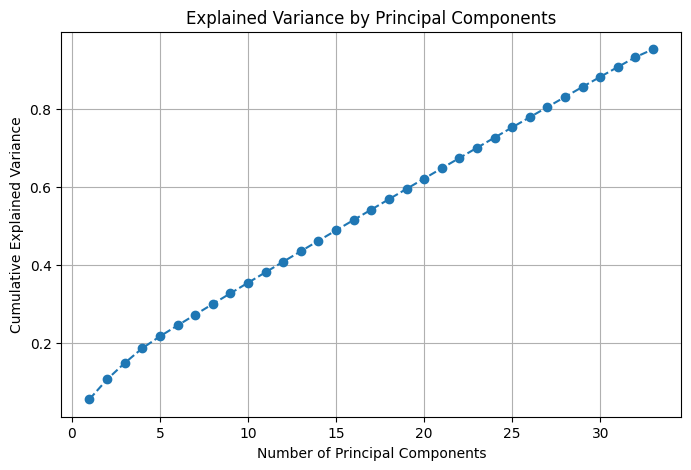

In [ ]:
import matplotlib.pyplot as plt
# Plot the explained variance ratio
plt.figure(figsize=(8, 5))
plt.plot(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

The graph seems to grow linearly, so there should not be a reason to cut off the components early. If it were to grow logarithmically, perhaps we would have chosen to limit the number of components. In the end, we chose to stick with the 33 components.

##One Final Check before Modeling

In [ ]:
# Final Training and Test Data
print("Final Training Data Shape (PCA):", X_train_pca.shape)
print("Final Test Data Shape (PCA):", X_test_pca.shape)

Final Training Data Shape (PCA): (47036, 33)
Final Test Data Shape (PCA): (11760, 33)


# Part 5: Modeling

After the data pre-processing, we are now ready for modeling. The main goal of the models is to be predictive, i.e. to estimate the price based on the features, rather than to look at the features themselves. This will be explored more later on.

## Part 5.1: Linear Regression as Baseline Model

Linear Regression serves as a decent baseline model to evaluate how well the features explain ride prices. This model will be trained on the PCA-transformed data

In [ ]:
# Initialize the Linear Regression model
lr = LinearRegression()

# Train the model on the PCA-transformed training data
lr.fit(X_train_pca, y_train)

# Predict on the test data
y_pred_lr = lr.predict(X_test_pca)

###Evaluating the Model
We evaluate the model in term of $R^2$ score, which measures the proportion of variance explained by the model, and Root Mean Squared Error, which shows how off the model is.

In [ ]:
# Calculate RMSE and R² score
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
lr_score_train = lr.score(X_train_pca, y_train)
lr_score_test = lr.score(X_test_pca, y_test)

# Print the evaluation results
print("\nLinear Regression Performance:")
print(f"RMSE: {rmse_lr:.2f}")
print(f"Training Set R² value: {lr_score_train:.4f}")
print(f"Test Set R² value: {lr_score_test:.4f}")


Linear Regression Performance:
RMSE: 3.56
Training Set R² value: 0.8496
Test Set R² value: 0.8533


The model already seems to do very well on the data (surprisingly high $R^2$ and low RMSE). Therefore, we are very confident that the features explain the price very well and we are optimistic about what the next models can do.

###Checking Assumptions of Linear Regression
Here we want to look into the residuals and see a more in-depth view of how the model performs.

###Residual Analysis

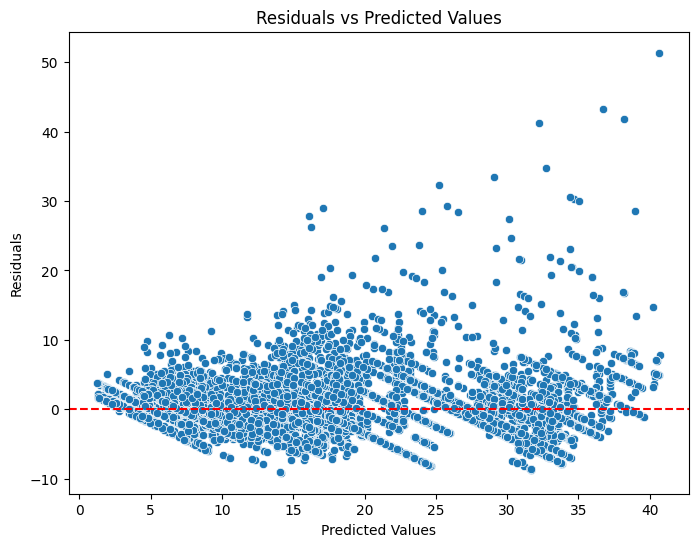

In [ ]:
# Calculate residuals
residuals = y_test - y_pred_lr

# Plot residuals vs predicted values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred_lr, y=residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

The pattern look fairly decent. However, it is fanning out a little bit when with the increase in predicted values. This might mean that the model struggles at certain ranges of data. But, as a baseline model, it is more than satisfactory.

###Normality of Residuals

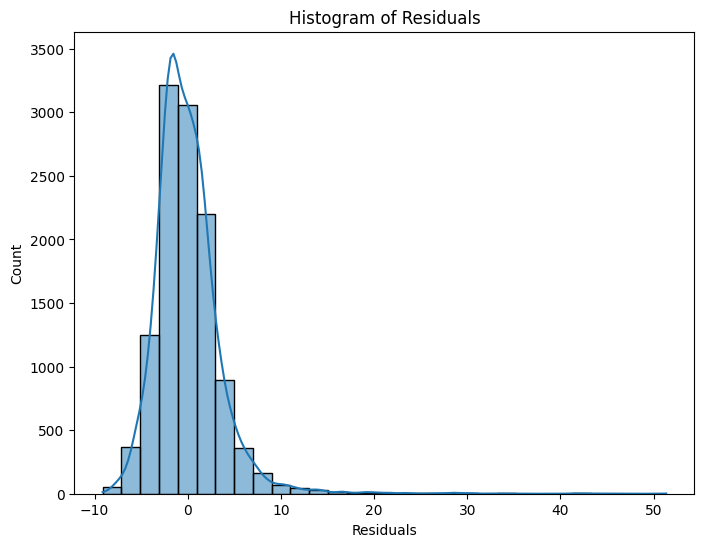

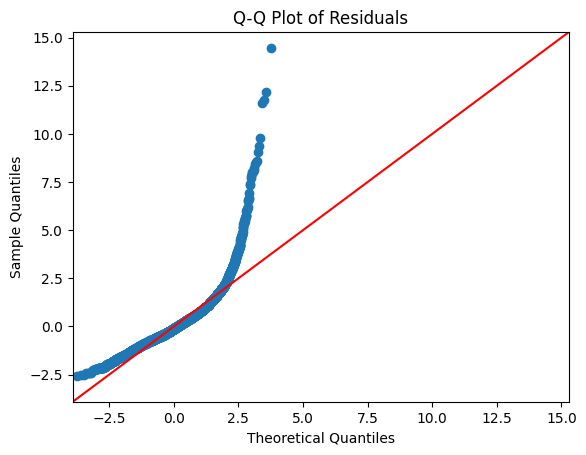

In [ ]:
# Histogram of residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.show()

# Q-Q plot
sm.qqplot(residuals, line='45', fit=True)
plt.title("Q-Q Plot of Residuals")
plt.show()

The **Histogram** shows a very good curve around the zero point, meaning that the prediscions are fairly unbiased and the errors are normally distributed FOR THE MOST PART - there seem to be a few outliers which are better described in the next plot.


The **Q-Q** plot shows an upward curve in the higher quantiles, indicating that the residuals are right-skewed. This suggests the model tends to underpredict ride prices for higher values. The deviation highlights that the linear model may not fully capture the complex relationships in the data, particularly for extreme ride prices. To address this, we would want to use non linear models like Random Forest or FCN.

###Conclusion for Linear Regression

The model is performing surprisingly well overall and the distribution is fairly normal for the most part.

Having done the PCA beforehand, we feel comfortable with the degree of tuning that was performed for this model. By retaining 95% of the variance, PCA ensured that we preserved the most significant information while reducing the complexity of the feature set. This approach not only improved computational efficiency but also helped mitigate issues such as multicollinearity, which can negatively impact the performance of linear regression models.

However, there seem to be a few outliers, where the model underestimates the price of the actual ride. Even though performance is satisfactory as a baseline, we hope to see better performance in the next two models.

## Part 5.2: Random Forest Regression

Because we wanted to focus on a non-linear model given the insight from the Linear Regression model, we chose to implement a Random Forest Regression model to predict the price data. Because of its scale invariance, we did not use the PCA data but rather the original data.

###Initialize and train

In [ ]:
# Initialize the Random Forest object
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the Random Forest model
rf_regressor.fit(X_train, y_train)
print("\nRandom Forest Model Trained Successfully!")


Random Forest Model Trained Successfully!


###Make the predictions

In [ ]:
# Predict on the training set
y_train_pred_rf = rf_regressor.predict(X_train)

# Predict on the test set
y_test_pred_rf = rf_regressor.predict(X_test)



###Evaluate the Performance of the Models

Same as before, we compute the $R^2$ score and RMSE to see how good the model's predictions are.

In [ ]:
# Calculate R² scores for training and test sets
r2_rf_train = r2_score(y_train, y_train_pred_rf)
r2_rf_test = r2_score(y_test, y_test_pred_rf)

# Calculate RMSE for the test set
rmse_rf = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))

# Print model performance metrics
print("\nRandom Forest Model Performance:")
print(f"Training Set R² value: {r2_rf_train:.4f}")
print(f"Test Set R² value: {r2_rf_test:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf:.2f}")


Random Forest Model Performance:
Training Set R² value: 0.9875
Test Set R² value: 0.9125
Root Mean Squared Error (RMSE): 2.75


The values are great! Again, $R^2$ is incredibly high and RMSE is fairly low. When it comes to the r2 score, the fact that it is so high on the training set might create worries about overfitting. However, it is still performing really well on the test set.

###Hyperparameter Tuning Using RandomizedSearchCV

Because of the very high r2 score for training (which would indicate overfitting), we thought to implement RandomizedSearchCV to see if optimizing the hyperparameters would improve the performance of the model at all. We have exerimented with different param_dist (initial n_estimators \[100, 200, 500\]; max_depth \[6, 9, 12, 15\], min_samples_split \[2, 5, 10\]; min_samples_leaf \[1, 2, 4\]), narrowing the search space around the previously best hyperparameters, and introducing finer granularity in n_estimators and max_depth.

In [ ]:

# Define the parameter grid
param_dist = {
    'n_estimators': [300, 400, 500, 600],
    'max_depth': [12, 15, 18, None],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Random Forest model
rf = RandomForestRegressor(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=5,     # Number of random combinations to test
    cv=3,          # 5-fold cross-validation
    scoring='r2',
    verbose=2,
    random_state=42,
    n_jobs=-1      # Use all available CPU cores
)

# Fit RandomizedSearchCV on the training data
random_search.fit(X_train, y_train)

# Best hyperparameters
best_params = random_search.best_params_
print("\nBest Hyperparameters Found:")
print(best_params)

Fitting 3 folds for each of 5 candidates, totalling 15 fits

Best Hyperparameters Found:
{'n_estimators': 600, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_depth': 18}


After finding the best hyperparameters, evaluate the new performance of the model.

In [ ]:
# Train the Random Forest model with best parameters
rf_optimized = RandomForestRegressor(**best_params, random_state=42)

# Fit the model
rf_optimized.fit(X_train, y_train)

# Predict on training and test sets
y_train_pred_optimized = rf_optimized.predict(X_train)
y_test_pred_optimized = rf_optimized.predict(X_test)

# Evaluate the optimized model
r2_train_optimized = r2_score(y_train, y_train_pred_optimized)
r2_test_optimized = r2_score(y_test, y_test_pred_optimized)
rmse_optimized = np.sqrt(mean_squared_error(y_test, y_test_pred_optimized))

print("\nOptimized Random Forest Model Performance:")
print(f"Training Set R² value: {r2_train_optimized:.4f}")
print(f"Test Set R² value: {r2_test_optimized:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_optimized:.2f}")



Optimized Random Forest Model Performance:
Training Set R² value: 0.9516
Test Set R² value: 0.9199
Root Mean Squared Error (RMSE): 2.63


It seems like tuning the hyperparameters has succesfully made the model a little better. The training r2 is not as high as before, which was our main concern, and the test r2 was improved by a really small margin. The final model is very good overall and its accuracy is more than satisfactory.

###Feature Importance Analysis

Random Forest, as an ensemble method, not only provides strong predictive performance but also offers feature importance scores that help identify which features have the most significant impact on the model's predictions. Even though our main goal was prediction, this analysis enhances the interpretability of the model and provides valuable insights into the relationships between input features and the target variable.


Top 10 Important Features:
              Feature  Importance
30     name_Black SUV    0.264483
33  name_Lux Black XL    0.259476
0            distance    0.153502
32     name_Lux Black    0.094833
36        name_Shared    0.046931
34          name_Lyft    0.039521
38         name_UberX    0.032882
40           name_WAV    0.031742
37      name_UberPool    0.027794
39        name_UberXL    0.007816


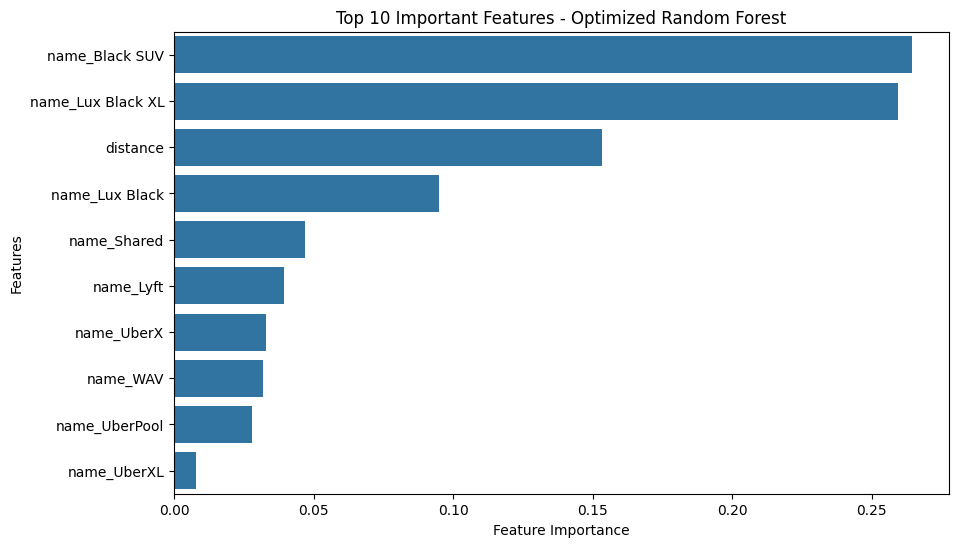

In [ ]:
# Extract feature importance
importances = rf_optimized.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display the top 10 important features
print("\nTop 10 Important Features:")
print(feature_importance_df.head(10))

# Plot the top 10 features

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.title("Top 10 Important Features - Optimized Random Forest")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.show()


This shows that weather is not as important as the other features when predicting price. This also has to do with the dataset. Because the time frame is not large, there was not enough weather data for it to become relevant, something that was explained earlier. Car/ride type and distance are most important, whereas time and weather are not included in the top list.

## Part 5.3: Fully Connected Neural Network
The final model we wanted to implement is an FCN. The reasoning for this is related to our main goal: prediction of price. Therefore, we choose to sacrifice feature importance and analysis for a more predictive model that would output the best results.

###Model Initialization

Compared to other possible implementations, we decided to use the Keras Sequential API for both simplicity of use and simplicity of understanding.

The Sequential model is initialized as a linear stack of layers, where each layer is added step-by-step. The first layer is a Dense layer with 128 neurons, a ReLU activation function to introduce non-linearity, and an input shape matching the number of features in the training data. A Dropout layer follows, with 20% of the neurons randomly deactivated during training to prevent overfitting. The second hidden layer consists of 64 neurons, also using ReLU activation, followed by another Dropout layer for further regularization. The final output layer has a single neuron with a linear activation function, suitable for regression tasks as it outputs continuous values.

The model is compiled with the Adam optimizer, an adaptive optimization algorithm that efficiently adjusts learning rates for faster convergence. The Mean Squared Error (MSE) loss function is specified to minimize the squared difference between predicted and actual values, a standard choice for regression. Additionally, Mean Absolute Error (MAE) is used as a monitoring metric during training. The model summary provides a detailed overview of the layers, output shapes, and total trainable parameters, which is particularly useful for debugging and understanding the model’s architecture. This implementation in Keras demonstrates how to quickly build, regularize, and compile a neural network for regression tasks with just a few lines of clean and intuitive code.

In [ ]:
# Initialize the FCN model
fcn_model = Sequential()

# Input Layer and First Hidden Layer
fcn_model.add(Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)))
fcn_model.add(Dropout(0.2))  # Dropout for regularization

# Second Hidden Layer
fcn_model.add(Dense(64, activation='relu'))
fcn_model.add(Dropout(0.2))

# Output Layer
fcn_model.add(Dense(1, activation='linear'))  # Linear activation for regression

# Compile the model
fcn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Summary of the model
fcn_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           5,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,697 (53.50 KB)

 Trainable params: 13,697 (53.50 KB)

 Non-trainable params: 0 (0.00 B)

###Training

This code trains the FCN using the Keras fit() function. It iteratively updates the model's weights over 50 epochs with batches of 32 samples at a time. During training, the model's performance is evaluated on the validation data, allowing us to monitor generalization and overfitting. The training history provides a record of the loss and metrics, enabling further analysis and fine-tuning of the model. This process showcases the power of Keras for training neural networks efficiently with minimal code.

In [ ]:
# Train the FCN model
history = fcn_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 50.8476 - mae: 4.3076 - val_loss: 7.6941 - val_mae: 1.6000
Epoch 2/50
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 12.1358 - mae: 2.2364 - val_loss: 7.7351 - val_mae: 1.5360
Epoch 3/50
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 10.4113 - mae: 2.0762 - val_loss: 7.2790 - val_mae: 1.5045
Epoch 4/50
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 10.6631 - mae: 2.0569 - val_loss: 7.0863 - val_mae: 1.5079
Epoch 5/50
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 10.4283 - mae: 2.0260 - val_loss: 7.1879 - val_mae: 1.4854
Epoch 6/50
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 10.0770 - mae: 1.9804 - val_loss: 7.1140 - val_mae: 1.5792
Epoch 7/50
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 10.7144 - mae: 1.9913 - val_loss: 7.1492 - val_mae: 1.5668
Epoch 8/50
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 10.0209 - mae: 1.9412 - val_loss: 7.2234 - val_mae: 1.4484
Epoch 9/50
1470/1470 ━━━━━━━━━━━

###Model Evaluation

The metrics for evaluation are the same as before: r2 and RMSE.

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Predict on the test set
y_train_pred_fcn = fcn_model.predict(X_train_scaled)
y_test_pred_fcn = fcn_model.predict(X_test_scaled)
r2_train_fcn = r2_score(y_train, y_train_pred_fcn)
r2_test_fcn = r2_score(y_test, y_test_pred_fcn)
# Calculate RMSE and R² Score
rmse_fcn = np.sqrt(mean_squared_error(y_test, y_test_pred_fcn))
r2_test_fcn = r2_score(y_test, y_test_pred_fcn)
r2_train_fcn = r2_score(y_train, y_train_pred_fcn)

# Print results
print("\nFully Connected Neural Network Performance:")
print(f"Root Mean Squared Error (RMSE): {rmse_fcn:.2f}")
print(f"Train R² Score: {r2_train_fcn:.4f}")
print(f"Test R² Score: {r2_test_fcn:.4f}")

1470/1470 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Fully Connected Neural Network Performance:
Root Mean Squared Error (RMSE): 2.64
Train R² Score: 0.9219
Test R² Score: 0.9190


The results are really good! This model shows less overfitting than the previous model and has a great score for the test set. This has been the best performing model so far and is the most appropriate for our goals (prediction).

When changing the model for a better perforance, we might want to consider the number of neurons and hidden layers when it comes to both overfitting and performance.

###Visualizing Training and Validation Loss

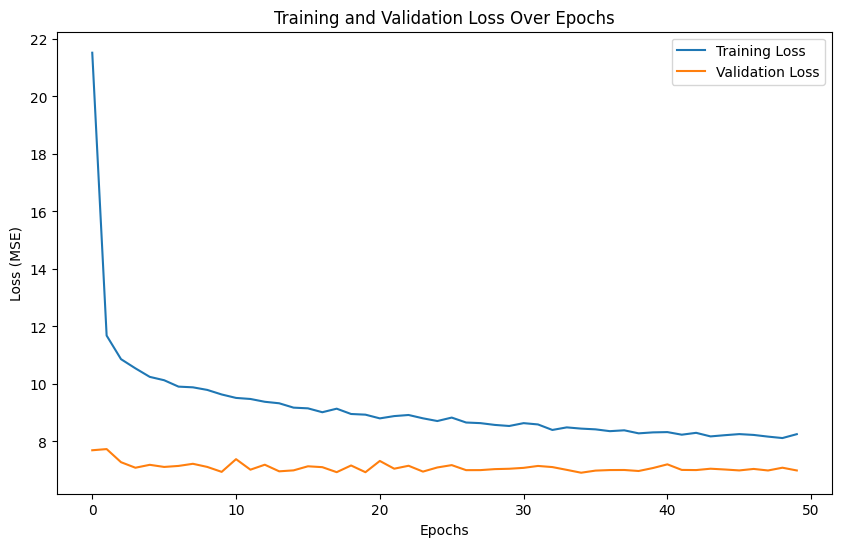

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

Given that the Validation loss does not change greatly throughout all epochs, it is unnecessary to use all 50. Therefore, we might want to stop at around 25 epochs in the future, where the training validation seems to plateau as well.